<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-MilepostAtTime-40Min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


     |████████████████████████████████| 719 kB 5.1 MB/s 
     |████████████████████████████████| 362 kB 17.5 MB/s 
     |████████████████████████████████| 1.2 MB 49.0 MB/s 
     |████████████████████████████████| 4.4 MB 33.0 MB/s 
     |████████████████████████████████| 212 kB 45.9 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 1.1 MB 14.2 MB/s 
     |████████████████████████████████| 140 kB 38.3 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 127 kB 46.9 MB/s 
     |████████████████████████████████| 144 kB 49.0 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 50.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.

In [2]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"

#events-20-min includes reports for all trains in the a 2 week window reporting at most every 20 minutes 
filename = "train-events-20-min.zip"

# miles answers the question "what spped will this train be moving in X miles (technically at milepost +/-X)"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }

# minutes answers the question : what speed will this train be moving in X Minutes
#measurement = { 'unit' : 'minutes', 'size' : 90.0 }

#dep_var = 'nextSpeed'

# milepost answers the question "What milepost will this train be at in X Minutes"
measurement = { 'unit' : 'milepost', 'size' : 40.0 }
dep_var = 'nextValue'

In [3]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-events-20-min.zip...
- [1 files][ 40.7 MiB/ 40.7 MiB]                                                
Operation completed over 1 objects/40.7 MiB.                                     


In [4]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   22:01:56
2000   22:02:09
3000   22:02:19
4000   22:02:25
5000   22:02:30
6000   22:02:36


In [5]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [6]:
del trains

In [7]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6747 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            6747 non-null   object 
 1   positionHistoryList                                            6747 non-null   object 
 2   locomotiveList                                                 6747 non-null   object 
 3   subdivisionList                                                6747 non-null   object 
 4   trainEstimatedPositionList                                     6747 non-null   object 
 5   trainActualPositionList                                        6747 non-null   object 
 6   trainId.trainSCAC                                              6747 non-null   object 
 7   trainId.trainSection                                           

# Create a learning set to modify

In [8]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [9]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [10]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [11]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


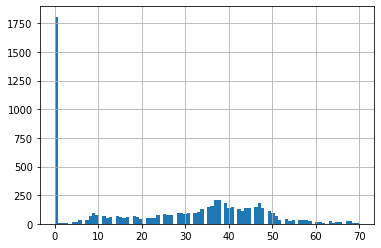

In [12]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [13]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [14]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [15]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['A' 'Q' 'M' 'H' 'G' 'U' 'I' 'O' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W']
['TO_S_UP_MAINLINE' 'WEST MAIN' 'EAST MAIN' 'TO_N_EAST MAIN' 'MAIN' 'S_LUCAS' 'NEW LACY TRACK' 'MAIN CHAISON YARD' 'MT 2' 'MT 1' 'S_VIDOR' 'TO_S_VIDOR' 'TO_S_CS JUNCTION' 'S_HELME' 'EASTXO'
 'TO_S_KCS UP PRT CONN' 'KCS UP PORT CONNECT' 'WESTXO' 'N SIDING' 'XO' 'TO_N_HELME' 'TO_N_CHAISON MAIN' 'TO_N_LUCAS' 'TO_N_STARKS' 'S_STARKS' 'S_MAURICEVILLE' 'TO_S_LUCAS' 'TO_N_MAURICEVILLE' 'YD LD'
 'TO_N_VIDOR' 'S_FISHER' 'S_CONVERSE' 'S_ANACOCO' 'S_NEAME' 'S_LEESVILLE']
['UP']
['' '2' '3' '4' '5']
[1. 2. 0. 4. 3.]
[14. 12.  0.  9.  8. 10. 18. 15.  4. 20. 11.  2. 17. 16. 13. 19.]
[2. 0. 3. 1.]
[3. 0. 2.]
['AMTK' 'BNSF' 0.0 '' 'KCS']
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [16]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45. 30.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [17]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [18]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [19]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '225.10', '202.20,219.70', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '250.50,202.20', '258.40,202.20', '258.40,207.60,202.20', '321.50,202.20', '202.20,314.52',
       '202.20,214.50,225.10,290.80,304.10', '214.50,225.10,290.80,304.10,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '258.40,214.50,202.20', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [20]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [21]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [22]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])


You can peer into the incoming data here:

In [23]:
idx = 201
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

KCS4151
MRNWAJ


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-07-01T02:21:09Z,0,106,WEST MAIN,766.24380
1,2022-07-01T02:23:09Z,0,106,WEST MAIN,766.24380
2,2022-07-01T02:25:09Z,-1,106,WEST MAIN-MAIN,766.19920
3,2022-07-01T02:27:09Z,-5,106,WEST MAIN-MAIN,766.11084
4,2022-07-01T02:29:09Z,-9,106,MAIN,765.94490
...,...,...,...,...,...
16,2022-07-01T02:53:09Z,-8,106,S_VIDOR,761.16580
17,2022-07-01T02:55:09Z,-7,106,S_VIDOR,760.92035
18,2022-07-01T02:57:09Z,-6,106,S_VIDOR,760.67960
19,2022-07-01T02:59:09Z,-4,106,S_VIDOR,760.45135


In [24]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,764.8696,[]
0,764.8706,[]
0,766.9310,[]
0,764.8691,[]
0,766.9302,[]
...,...,...
0,290.7408,"[{'positionTime': '2022-06-23T10:15:47Z', 'speedMPH': 12, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 290.7408}}}, {'positionTime': '2022-06-23T10:17:47Z', 'speedMPH': 30, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 291.4418}}}, {'positionTime': '2022-06-23T10:19:47Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 292.6651}}}, {'positionTime': '2022-06-23T10:21:47Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId':..."
0,293.2164,[]
0,294.0817,"[{'positionTime': '2022-06-23T11:17:23Z', 'speedMPH': 23, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 294.0817}}}, {'positionTime': '2022-06-23T11:19:23Z', 'speedMPH': 35, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 295.03876}}}, {'positionTime': '2022-06-23T11:21:23Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 296.39496}}}, {'positionTime': '2022-06-23T11:23:23Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106..."
0,305.3550,"[{'positionTime': '2022-06-23T11:34:06Z', 'speedMPH': 48, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 305.355}}}, {'positionTime': '2022-06-23T11:36:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 307.01364}}}, {'positionTime': '2022-06-23T11:38:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 308.68835}}}, {'positionTime': '2022-06-23T11:40:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."


Renumber the list

In [25]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextValue
This will be the value we are attempting to learn

In [26]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return (abs(actualsEntry.iloc[idx]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
  return None

In [27]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [28]:
def findNextMilepostAtTime(trainsEntry, actualsEntry, timeInMinutes):
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return actualsEntry.iloc[idx]['milepostLocation.milepost.milepostNumber']
  return None

In [29]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  elif (measurement.get('unit') == 'milepost'):
    return findNextMilepostAtTime(trainsEntry, actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [30]:
idx = 3291
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 1)
print("Next Speed at MP:",nextActual)
nextActual = findNextTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Next Speed at 10 Min:",nextActual)
nextActual = findNextMilepostAtTime(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], 10)
print("Milepost in 10 Min:",nextActual)

print("actual Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx]))
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, 1)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))

UP6579
CNAPW9
Reported speed:  42
Reported MP:  315.8773
Reported Time:  2022-06-26T02:15:16Z
Next Speed at MP:            positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-06-26T02:17:16Z       -43                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 2                                 314.40375  
Next Speed at 10 Min: 8
Milepost in 10 Min: 306.50928
actual Value:  281.48285
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-06-26T02:17:16Z       -44                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 2                                  314.4466  
beop Value:  283.04987


Run the calulations.  This will take a moment.

In [31]:
dfTrainsLearn['nextValue'] = np.NaN
dfTrainsLearn['beopValue'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextValue = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextValue != None):
    dfTrainsLearn.at[i,'nextValue'] = nextValue
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'milepost'):
        nextBeop = findNextMilepostAtTime(trainsEntry, beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'beopValue'] = nextBeop
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000


In [32]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextValue'])
dfTrainsLearn['nextValue'].unique()

array([728.6966 , 728.6964 , 728.6978 , ..., 293.2243 , 312.63773, 325.63818])

NextSpeed values histogram:


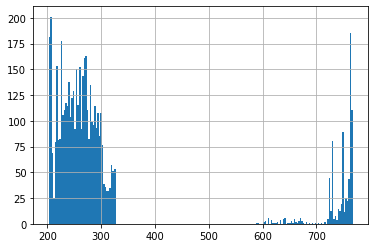

In [33]:
print("NextValue values histogram:")
dfTrainsLearn['nextValue'].hist(bins=200)

In [34]:
dfTrainsLearn['beopValue'].unique()

array([748.4721 , 755.1316 ,       nan, ..., 319.19366, 320.7019 , 325.82587])

physics predictions histogram:


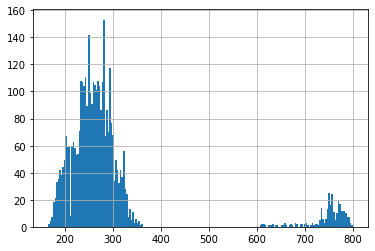

In [35]:
print("physics predictions histogram:")
dfTrainsLearn['beopValue'].hist(bins=200)

In [36]:
dfTrainsNextBeop = dfTrainsLearn['beopValue']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [37]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'beopValue',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [38]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
34,BNSF5833,UP,,MNOEW,...,False,False,False,1.655754e+09
35,BNSF5833,UP,,MNOEW,...,False,False,False,1.655755e+09
36,BNSF5833,UP,,MNOEW,...,False,False,False,1.655756e+09
37,BNSF5833,UP,,MNOEW,...,False,False,False,1.655757e+09
38,BNSF5833,UP,,MNOEW,...,False,False,False,1.655758e+09
...,...,...,...,...,...,...,...,...,...
6740,UP9101,UP,,MCHCB,...,False,False,False,1.655977e+09
6741,UP9101,UP,,MCHCB,...,False,False,False,1.655978e+09
6742,UP9101,UP,,MCHCB,...,False,False,False,1.655979e+09
6743,UP9101,UP,,MCHCB,...,False,False,False,1.655982e+09


In [39]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[10])

(5258, 47)
(6747,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5258 entries, 34 to 6744
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            5258 non-null   object        
 1   trainId.trainSCAC                                              5258 non-null   category      
 2   trainId.trainSection                                           5258 non-null   category      
 3   trainId.trainSymbol                                            5258 non-null   object        
 4   trainId.trainDate                                              5258 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  5258 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            5258 non-null

# Use Decision Tree to predict next speed

In [40]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [41]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
171    399
172    404
173    467
174    631
175    517
176    471
177    487
178    450
179    451
180    432
181    452
182     97
Name: lastReportedPosition.positionTimeDayofyear, dtype: int64


In [42]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * .66)])

We will partition this set at day of year: 178


In [43]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * .66)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [44]:
#dep_var = 'nextSpeed'

In [45]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [46]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [47]:
len(to.train),len(to.valid)

(3826, 1432)

In [48]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextValue
34,BNSF5833,UP,,MNOEW,2022-06-19,106,MAIN,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,8,720.410889,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,720,1,6,25,20,0,171,1.655754e+09,728.696594
35,BNSF5833,UP,,MNOEW,2022-06-19,106,MAIN,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,28,724.460693,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,724,1,6,25,20,0,171,1.655755e+09,728.696411
36,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696106,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655756e+09,728.697815
37,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696411,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655757e+09,728.697021
38,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.697998,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655758e+09,728.696777
39,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.697388,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655759e+09,728.696777
40,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655761e+09,728.696777
41,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655762e+09,728.696106
42,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696777,100343000.0,857270.0,4200000.0,8780.0,65535.0,6.0,0.0,0.0,0.0,50.0,10.0,115.0,7274.0,5018.0,728,1,6,25,20,0,171,1.655763e+09,728.695679
43,BNSF5833,UP,,MNOEW,2022-06-19,106,S_LUCAS,4.0,12.0,2.0,2.0,0.0,True,M,#na#,2022,False,False,False,False,False,False,0,728.696594,100343000.0,857270.0,4200000.0,87

In [49]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [50]:
to = fastai.load_pickle('/tmp/to.pkl')

In [51]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [52]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

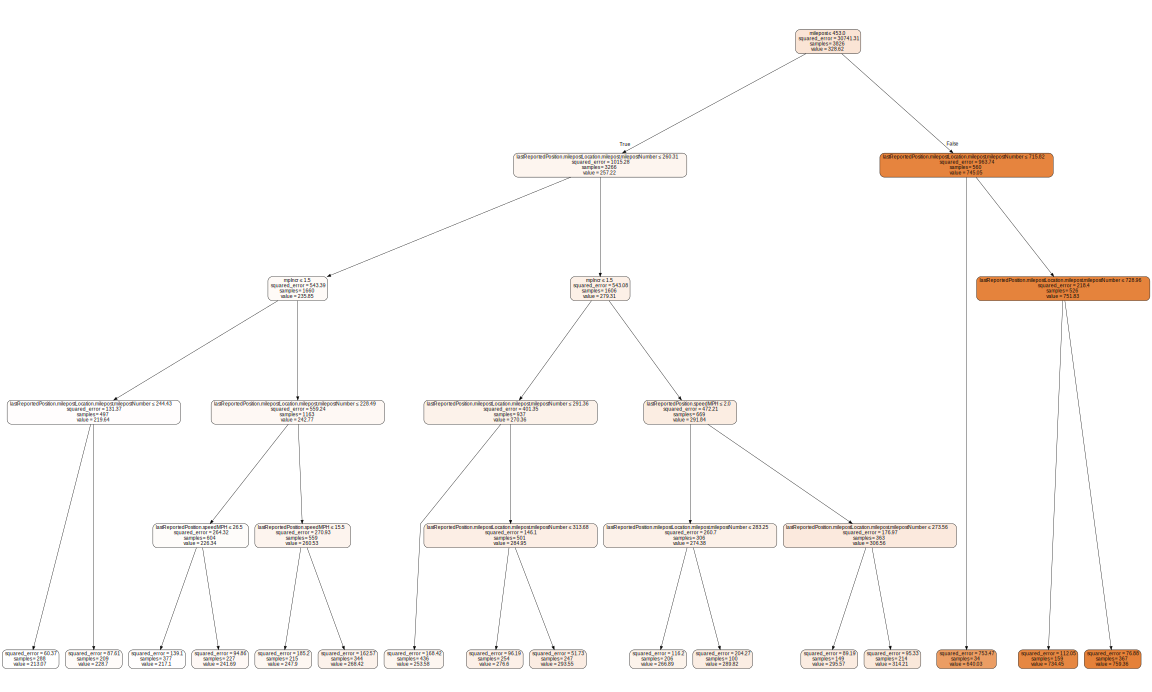

In [53]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [54]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

In [55]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

How well we fit the traing model:

In [56]:
m_rmse(m, xs, y)

6.165543

How well we fit the Validation Model:

In [57]:
m_rmse(m, valid_xs, valid_y)

9.560298

In [58]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [59]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
38,milepost,0.968644
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.024345
12,mpIncr,0.003189
22,lastReportedPosition.speedMPH,0.003057
45,lastReportedPosition.positionTimeElapsed,0.000143
34,loadedCarCount,0.000089
35,emptyCarCount,0.000056
3,trainId.trainSymbol,0.000055
13,symbolType,0.000050
36,trainLength,0.000049


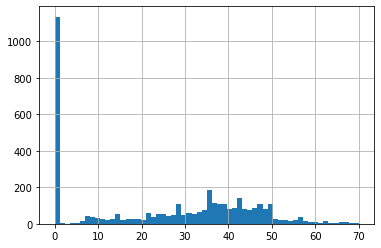

In [60]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


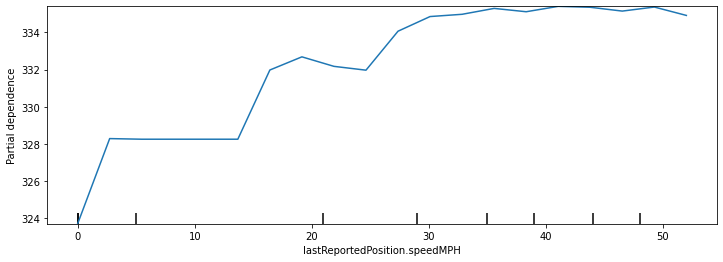

In [61]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [62]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [63]:
m = randomForest(xs, y);

In [64]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(6.104111, 8.660171)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [66]:
r_mse(preds.mean(0), valid_y)

8.660171

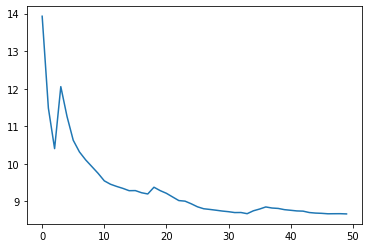

In [67]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [68]:
r_mse(m.oob_prediction_, y)

7.993047

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [70]:
preds.shape

(50, 1432)

In [71]:
preds_std = preds.std(0)

In [72]:
preds_std[:5]

array([25.28576072, 25.17129277,  8.85332443,  8.2834645 ,  4.86928941])

In [73]:
print(preds.mean(0)[:10])
print(valid_y[:10])

[756.00186754 755.68984648 218.71028068 219.00575407 237.8523521  245.91458001 257.01942788 267.68533665 283.19362299 292.98730374]
55     766.232605
56     765.379028
98     219.710281
99     230.957947
100    240.860855
101    250.790558
102    263.092224
103    274.378143
104    285.813904
105    297.657440
Name: nextValue, dtype: float32


# FEATURE Importance

In [74]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.583725
38,milepost,0.318818
14,workLocations,0.081188
39,locomotiveCount,0.007024
12,mpIncr,0.004464
22,lastReportedPosition.speedMPH,0.002277
6,lastReportedPosition.milepostLocation.trackName,0.000329
3,trainId.trainSymbol,0.000257
35,emptyCarCount,0.000149
36,trainLength,0.000145


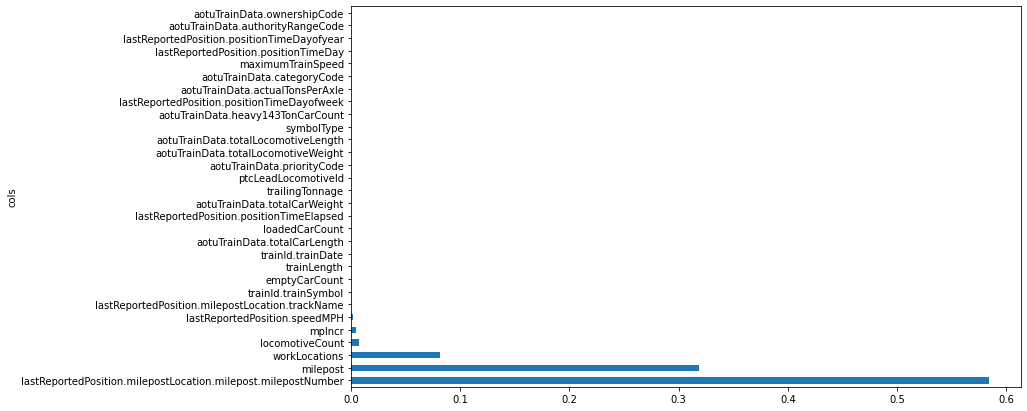

In [75]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [76]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

8

In [77]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [78]:
m = randomForest(xs_imp, y)

In [79]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(6.983037, 8.974705)

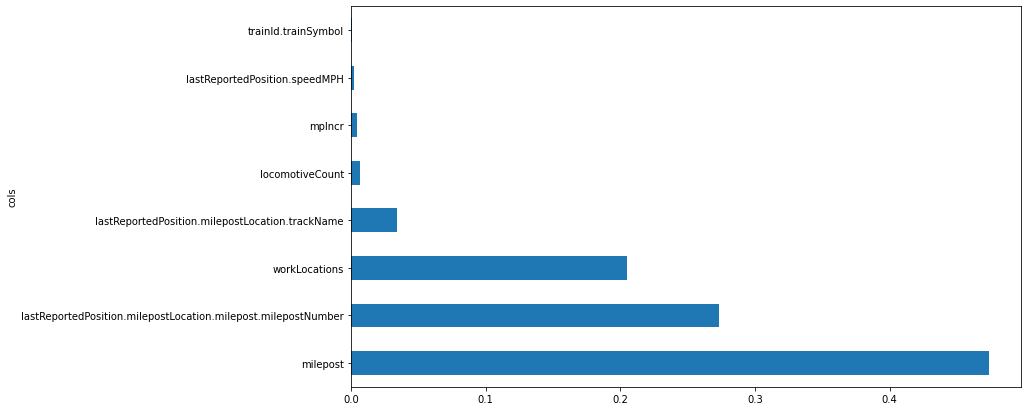

In [80]:
plot_fi(rf_feat_importance(m, xs_imp));

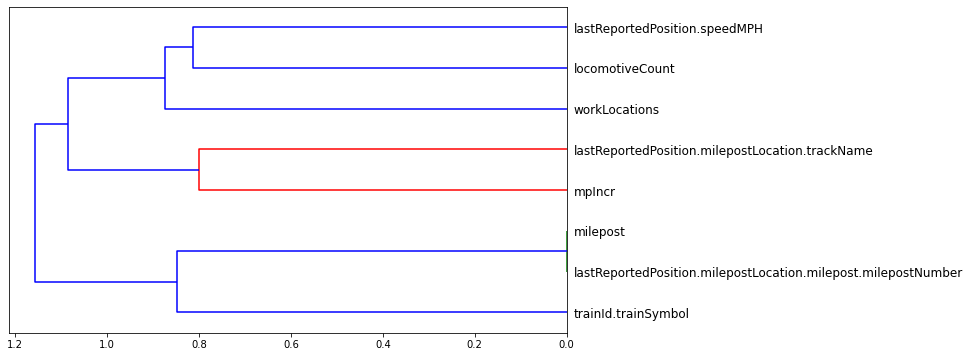

In [81]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [82]:
b = dfTrainsNextBeop.tail(14165)
# beopValues = beopValues.to_frame().join(valid_y)
#m_rmse(m, valid_xs_imp, valid_y)
b = b.reset_index(drop=true)
#print (b)
y = valid_y.reset_index(drop=true)
#print (y)
df2  = pd.concat([b, y], axis=1)
df2.dropna()
print(df2)
r_mse(df2['beopValue'], df2['nextValue'])
# print(BeopValidations[:5])
#print(valid_y[:5])

      beopValue   nextValue
0     748.47210  766.232605
1     755.13160  765.379028
2           NaN  219.710281
3           NaN  230.957947
4           NaN  240.860855
...         ...         ...
5253  306.02840         NaN
5254  319.19366         NaN
5255  320.70190         NaN
5256        NaN         NaN
5257  325.82587         NaN

[5258 rows x 2 columns]


253.503697

# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [83]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.497973
45,lastReportedPosition.positionTimeElapsed,0.346336
42,lastReportedPosition.positionTimeDay,0.092295
41,lastReportedPosition.positionTimeWeek,0.031655
4,trainId.trainDate,0.022331
43,lastReportedPosition.positionTimeDayofweek,0.005306
40,lastReportedPosition.positionTimeMonth,0.002186
19,lastReportedPosition.positionTimeIs_quarter_start,0.001919


Consider whether these values make sense

#Using a Neural Net

In [84]:
df_nn_final = dfTrainsLearn

In [85]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5258 entries, 34 to 6744
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            5258 non-null   object        
 1   trainId.trainSCAC                                              5258 non-null   category      
 2   trainId.trainSection                                           5258 non-null   category      
 3   trainId.trainSymbol                                            5258 non-null   object        
 4   trainId.trainDate                                              5258 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  5258 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            5258 non-null   int64         
 

In [86]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [87]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [88]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    402
trainId.trainSCAC                                        1
trainId.trainSection                                     4
trainId.trainSymbol                                    150
trainId.trainDate                                       19
lastReportedPosition.speedMPH                           70
lastReportedPosition.milepostLocation.subdivisionId      1
lastReportedPosition.milepostLocation.trackName         32
aotuTrainData.priorityCode                               5
aotuTrainData.categoryCode                              13
aotuTrainData.authorityRangeCode                         4
aotuTrainData.ownershipCode                              3
aotuTrainData.eventCode                                  1
milepost                                               220
mpIncr                                                   2
symbolType                                              14
workLocations                                           

In [89]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [90]:
dls = to_nn.dataloaders(1024)

In [91]:
y = to_nn.train.y
y.min(),y.max()

(202.2869, 767.9996)

In [92]:
learn = tabular_learner(dls, y_range=(202,768), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.001737800776027143)

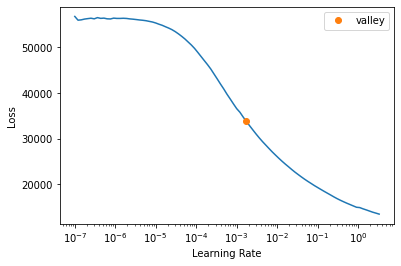

In [93]:
learn.lr_find()

In [94]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,time
0,38205.335938,55841.777344,00:00
1,23808.093750,54805.273438,00:00
2,17203.556641,51320.910156,00:00
3,13232.517578,48107.699219,00:00
4,10638.047852,45558.914062,00:00
5,8981.413086,44237.582031,00:00
6,7798.141602,45765.515625,00:00
7,6948.179199,42121.308594,00:00
8,6242.219238,32039.527344,00:00
9,5677.499023,24435.105469,00:00


In [95]:
preds,targs = learn.get_preds()
print(r_mse(preds,targs))
print(preds[:10])
print(targs[:10])

23.749931
tensor([[768.0000],
        [768.0000],
        [219.5950],
        [217.9125],
        [231.0936],
        [239.9344],
        [247.5324],
        [252.9111],
        [271.5499],
        [294.7817]])
tensor([[766.2326],
        [765.3790],
        [219.7103],
        [230.9579],
        [240.8609],
        [250.7906],
        [263.0922],
        [274.3781],
        [285.8139],
        [297.6574]])
